# Benchmarking Optimization Techniques

**Module 03 | Notebook 5 of 5**

This notebook provides a comprehensive comparison of all optimization techniques covered in this module.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Set up a standardized benchmarking framework
2. Compare latency, memory, and accuracy across techniques
3. Visualize trade-offs effectively
4. Choose the best optimization for your use case

---
### Prerequisites
- Familiarity with PyTorch and Hugging Face Transformers
- Understanding of Pruning and Quantization (Notebooks 03 & 04)
- (Optional) GPU for benchmarking FP16/INT8 speedups

---

In [1]:
%%capture
!pip install transformers torch datasets matplotlib pandas seaborn tabulate

In [2]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import gc
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## Setup: Load Base Model and Data

In [3]:
# Load model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name)

print(f"Base model: {model_name}")
print(f"Parameters: {sum(p.numel() for p in base_model.parameters()):,}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Base model: distilbert-base-uncased-finetuned-sst-2-english
Parameters: 66,955,010


In [4]:
# Load test data
dataset = load_dataset("glue", "sst2")
test_data = dataset['validation'].shuffle(seed=42).select(range(100))

print(f"Test samples: {len(test_data)}")

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Test samples: 100


---

## Benchmarking Utilities

In [5]:
def get_model_size_mb(model):
    """Calculate model size in MB."""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024**2)

def get_sparsity(model):
    """Calculate model sparsity percentage."""
    total = 0
    zeros = 0
    for p in model.parameters():
        total += p.numel()
        zeros += (p == 0).sum().item()
    return zeros / total * 100

def measure_latency(model, tokenizer, text, device, n_runs=50):
    """Measure inference latency in milliseconds."""
    model = model.to(device)
    model.eval()
    
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Warmup
    with torch.no_grad():
        for _ in range(5):
            _ = model(**inputs)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Measure
    times = []
    for _ in range(n_runs):
        start = time.time()
        with torch.no_grad():
            _ = model(**inputs)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        times.append((time.time() - start) * 1000)
    
    return np.mean(times), np.std(times)

def evaluate_accuracy(model, tokenizer, test_data, device):
    """Evaluate model accuracy."""
    model = model.to(device)
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for example in test_data:
            inputs = tokenizer(
                example['sentence'],
                return_tensors='pt',
                truncation=True,
                max_length=128
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            pred = outputs.logits.argmax(dim=-1).item()
            
            if pred == example['label']:
                correct += 1
    
    return correct / len(test_data) * 100

---

## Create Optimized Models

In [6]:
import torch.nn.utils.prune as prune

def apply_pruning(model, amount=0.3):
    """Apply L1 unstructured pruning."""
    model = deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model

def apply_quantization(model):
    """Apply INT8 dynamic quantization."""
    return torch.quantization.quantize_dynamic(
        deepcopy(model),
        {torch.nn.Linear},
        dtype=torch.qint8
    )

In [7]:
# Create all model variants
models = {}

print("Creating model variants...")

# 1. Baseline (FP32)
models['Baseline (FP32)'] = deepcopy(base_model)
print("  ✓ Baseline")

# 2. INT8 Quantized
models['Quantized (INT8)'] = apply_quantization(base_model)
print("  ✓ INT8 Quantized")

# 3. Pruned 30%
models['Pruned (30%)'] = apply_pruning(base_model, amount=0.3)
print("  ✓ Pruned 30%")

# 4. Pruned 50%
models['Pruned (50%)'] = apply_pruning(base_model, amount=0.5)
print("  ✓ Pruned 50%")

# 5. Pruned + Quantized
pruned_model = apply_pruning(base_model, amount=0.3)
models['Pruned (30%) + INT8'] = apply_quantization(pruned_model)
print("  ✓ Pruned + Quantized")

print(f"\nTotal variants: {len(models)}")

Creating model variants...
  ✓ Baseline
  ✓ INT8 Quantized
  ✓ Pruned 30%
  ✓ Pruned 50%
  ✓ Pruned + Quantized

Total variants: 5


---

## Run Benchmarks

In [8]:
# Benchmark all models
test_text = "This movie was absolutely fantastic! Great acting and amazing story."
results = []

print("Running benchmarks...\n")

for name, model in models.items():
    print(f"Benchmarking: {name}")
    
    # Size
    size = get_model_size_mb(model)
    
    # Sparsity
    sparsity = get_sparsity(model)
    
    # Latency (CPU only for quantized models)
    test_device = 'cpu' if 'INT8' in name else device
    latency_mean, latency_std = measure_latency(model, tokenizer, test_text, torch.device(test_device))
    
    # Accuracy
    accuracy = evaluate_accuracy(model, tokenizer, test_data, torch.device(test_device))
    
    results.append({
        'Model': name,
        'Size (MB)': size,
        'Sparsity (%)': sparsity,
        'Latency (ms)': latency_mean,
        'Latency Std': latency_std,
        'Accuracy (%)': accuracy,
        'Device': str(test_device)
    })
    
    print(f"  Size: {size:.1f}MB | Latency: {latency_mean:.2f}ms | Accuracy: {accuracy:.1f}%")
    
    # Clean up GPU memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nBenchmarking complete!")

Running benchmarks...

Benchmarking: Baseline (FP32)
  Size: 255.4MB | Latency: 5.42ms | Accuracy: 91.0%
Benchmarking: Quantized (INT8)
  Size: 91.0MB | Latency: 21.01ms | Accuracy: 92.0%
Benchmarking: Pruned (30%)
  Size: 255.4MB | Latency: 3.93ms | Accuracy: 90.0%
Benchmarking: Pruned (50%)
  Size: 255.4MB | Latency: 3.71ms | Accuracy: 84.0%
Benchmarking: Pruned (30%) + INT8
  Size: 91.0MB | Latency: 17.82ms | Accuracy: 91.0%

Benchmarking complete!


In [9]:
# Create results DataFrame
df = pd.DataFrame(results)

# Add relative metrics
baseline_latency = df[df['Model'] == 'Baseline (FP32)']['Latency (ms)'].values[0]
baseline_accuracy = df[df['Model'] == 'Baseline (FP32)']['Accuracy (%)'].values[0]
baseline_size = df[df['Model'] == 'Baseline (FP32)']['Size (MB)'].values[0]

df['Speedup'] = baseline_latency / df['Latency (ms)']
df['Size Reduction (%)'] = (1 - df['Size (MB)'] / baseline_size) * 100
df['Accuracy Drop (%)'] = baseline_accuracy - df['Accuracy (%)']

print("\n" + "=" * 100)
print("BENCHMARK RESULTS")
print("=" * 100)
print(df[['Model', 'Size (MB)', 'Latency (ms)', 'Accuracy (%)', 'Speedup', 'Accuracy Drop (%)']].to_string(index=False))


BENCHMARK RESULTS
              Model  Size (MB)  Latency (ms)  Accuracy (%)  Speedup  Accuracy Drop (%)
    Baseline (FP32)    255.417      5.419941          91.0 1.000000                0.0
   Quantized (INT8)     91.000     21.008039          92.0 0.257994               -1.0
       Pruned (30%)    255.417      3.927174          90.0 1.380112                1.0
       Pruned (50%)    255.417      3.707867          84.0 1.461741                7.0
Pruned (30%) + INT8     91.000     17.819486          91.0 0.304158                0.0


---

## Visualize Results

### 📈 Concept: The Pareto Frontier

When benchmarking, we look for the **Pareto Frontier**: the set of models where you cannot improve one metric (e.g., speed) without sacrificing another (e.g., accuracy).

- Models **on the frontier** are optimal choices depending on your constraints.
- Models **below the frontier** are suboptimal (there exists another model that is both faster AND more accurate).

In the plot below, look for models in the **top-left** (high accuracy, low latency) or **top-right** (if x-axis is speedup).

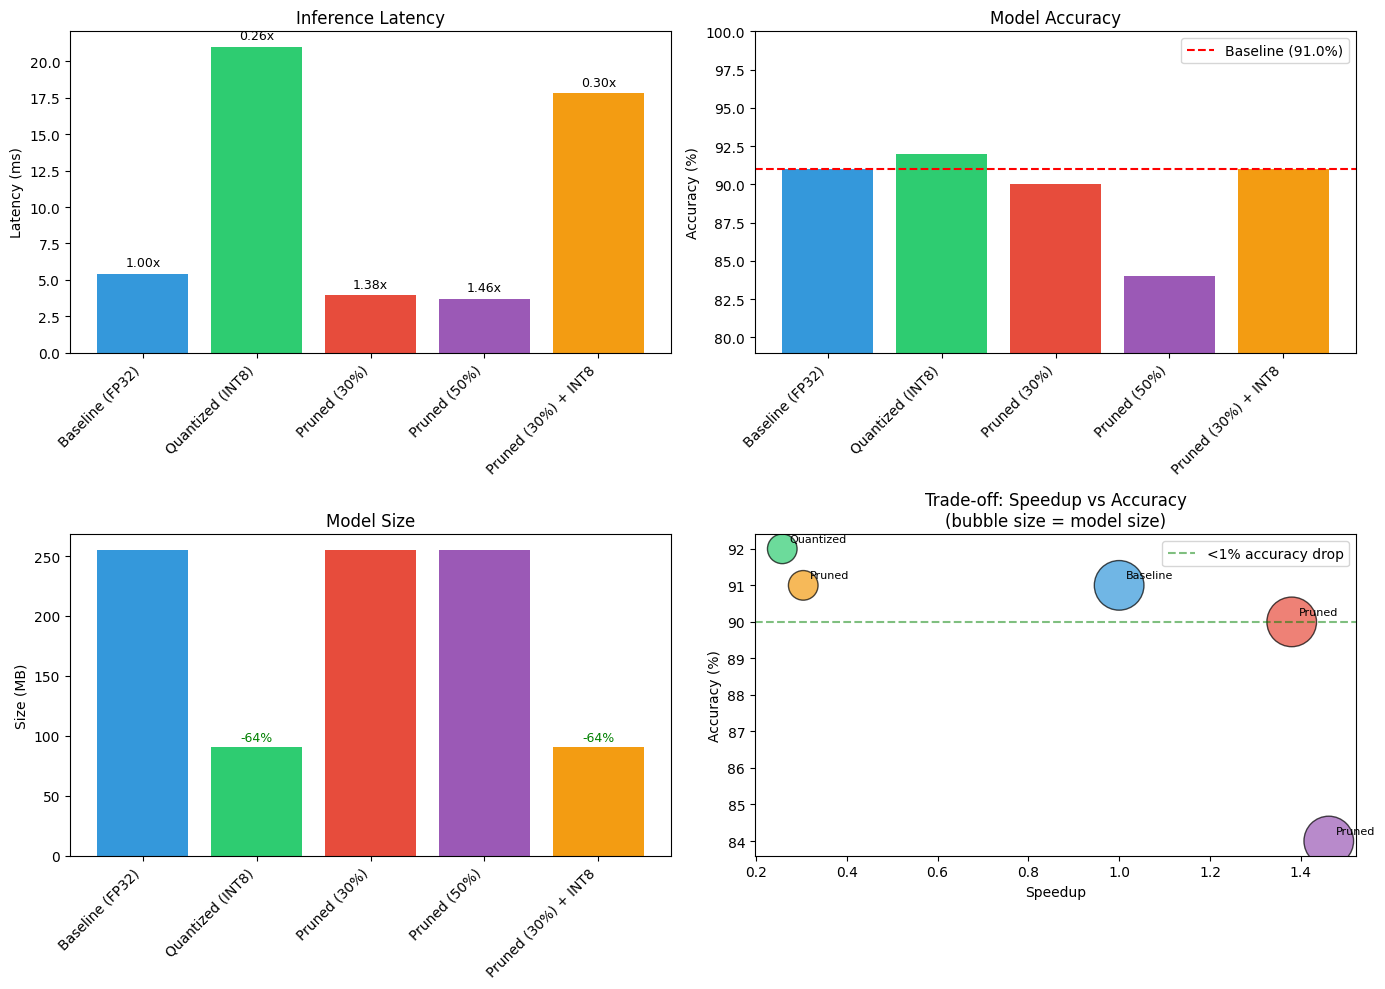

In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

# 1. Latency comparison
ax = axes[0, 0]
bars = ax.bar(df['Model'], df['Latency (ms)'], color=colors)
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference Latency')
ax.set_xticklabels(df['Model'], rotation=45, ha='right')
for bar, speedup in zip(bars, df['Speedup']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{speedup:.2f}x', ha='center', fontsize=9)

# 2. Accuracy comparison
ax = axes[0, 1]
bars = ax.bar(df['Model'], df['Accuracy (%)'], color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy')
ax.set_xticklabels(df['Model'], rotation=45, ha='right')
ax.set_ylim(min(df['Accuracy (%)']) - 5, 100)
ax.axhline(y=baseline_accuracy, color='red', linestyle='--', label=f'Baseline ({baseline_accuracy:.1f}%)')
ax.legend()

# 3. Size comparison
ax = axes[1, 0]
bars = ax.bar(df['Model'], df['Size (MB)'], color=colors)
ax.set_ylabel('Size (MB)')
ax.set_title('Model Size')
ax.set_xticklabels(df['Model'], rotation=45, ha='right')
for bar, reduction in zip(bars, df['Size Reduction (%)']):
    if reduction > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'-{reduction:.0f}%', ha='center', fontsize=9, color='green')

# 4. Trade-off scatter plot
ax = axes[1, 1]
scatter = ax.scatter(df['Speedup'], df['Accuracy (%)'], 
                     s=df['Size (MB)'] * 5, c=colors, alpha=0.7, edgecolors='black')
for i, row in df.iterrows():
    ax.annotate(row['Model'].split('(')[0].strip(), 
                (row['Speedup'], row['Accuracy (%)']),
                textcoords="offset points", xytext=(5, 5), fontsize=8)
ax.set_xlabel('Speedup')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Trade-off: Speedup vs Accuracy\n(bubble size = model size)')
ax.axhline(y=baseline_accuracy - 1, color='green', linestyle='--', alpha=0.5, label='<1% accuracy drop')
ax.legend()

plt.tight_layout()
plt.show()

---

## Recommendation Engine

In [11]:
def recommend_optimization(priority='balanced', accuracy_tolerance=1.0):
    """
    Recommend best optimization based on priority.
    
    Args:
        priority: 'speed', 'accuracy', 'size', or 'balanced'
        accuracy_tolerance: Maximum acceptable accuracy drop (%)
    """
    # Filter by accuracy tolerance
    candidates = df[df['Accuracy Drop (%)'] <= accuracy_tolerance].copy()
    
    if len(candidates) == 0:
        print(f"No models meet {accuracy_tolerance}% accuracy tolerance.")
        return None
    
    if priority == 'speed':
        best = candidates.loc[candidates['Speedup'].idxmax()]
    elif priority == 'accuracy':
        best = candidates.loc[candidates['Accuracy (%)'].idxmax()]
    elif priority == 'size':
        best = candidates.loc[candidates['Size (MB)'].idxmin()]
    else:  # balanced
        # Score based on speedup and accuracy retention
        candidates['Score'] = candidates['Speedup'] * (candidates['Accuracy (%)'] / 100)
        best = candidates.loc[candidates['Score'].idxmax()]
    
    return best

# Get recommendations
print("OPTIMIZATION RECOMMENDATIONS")
print("=" * 60)

for priority in ['speed', 'accuracy', 'size', 'balanced']:
    rec = recommend_optimization(priority=priority, accuracy_tolerance=2.0)
    if rec is not None:
        print(f"\nPriority: {priority.upper()}")
        print(f"  Recommended: {rec['Model']}")
        print(f"  Speedup: {rec['Speedup']:.2f}x")
        print(f"  Accuracy: {rec['Accuracy (%)']:.1f}%")
        print(f"  Size: {rec['Size (MB)']:.1f}MB")

OPTIMIZATION RECOMMENDATIONS

Priority: SPEED
  Recommended: Pruned (30%)
  Speedup: 1.38x
  Accuracy: 90.0%
  Size: 255.4MB

Priority: ACCURACY
  Recommended: Quantized (INT8)
  Speedup: 0.26x
  Accuracy: 92.0%
  Size: 91.0MB

Priority: SIZE
  Recommended: Quantized (INT8)
  Speedup: 0.26x
  Accuracy: 92.0%
  Size: 91.0MB

Priority: BALANCED
  Recommended: Pruned (30%)
  Speedup: 1.38x
  Accuracy: 90.0%
  Size: 255.4MB


---

## Export Results

In [12]:
# Save results to CSV
df.to_csv('./benchmark_results.csv', index=False)
print("Results saved to benchmark_results.csv")

# Print final summary
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"\nBaseline: {baseline_accuracy:.1f}% accuracy, {baseline_latency:.2f}ms latency")
print("\nBest optimizations within 1% accuracy drop:")
within_tolerance = df[df['Accuracy Drop (%)'] <= 1.0]
if len(within_tolerance) > 1:
    best_speedup = within_tolerance.loc[within_tolerance['Speedup'].idxmax()]
    print(f"  Fastest: {best_speedup['Model']} ({best_speedup['Speedup']:.2f}x speedup)")
    best_size = within_tolerance.loc[within_tolerance['Size (MB)'].idxmin()]
    print(f"  Smallest: {best_size['Model']} ({best_size['Size (MB)']:.1f}MB)")

Results saved to benchmark_results.csv

FINAL SUMMARY

Baseline: 91.0% accuracy, 5.42ms latency

Best optimizations within 1% accuracy drop:
  Fastest: Pruned (30%) (1.38x speedup)
  Smallest: Quantized (INT8) (91.0MB)


---

## 🎯 Student Challenge

### Challenge: Add More Optimization Combinations
<details>
<summary><strong>💡 Click for Hints/Solutions</strong></summary>

**1. FP16 Model:**
```python
model_fp16 = deepcopy(base_model).half()
# Note: .half() requires GPU execution for layers without CPU implementation
```

**2. Varying Pruning:**
```python
model_pruned_60 = apply_pruning(base_model, amount=0.6)
```

**3. Combined Strategy:**
```python
# Prune first, then quantize
pruned_50 = apply_pruning(base_model, amount=0.5)
model_combined = apply_quantization(pruned_50)
```
</details>

In [ ]:
# TODO: Extend the benchmark with additional combinations:

# 1. Add FP16 model (if GPU available)
# 2. Try different pruning levels (40%, 60%, 70%)
# 3. Create a combined "Pruned (50%) + INT8" variant
# 4. Update the visualization and recommendations

# Your solution:


---

## Key Takeaways

1. **Benchmarking is essential** before deploying optimized models
2. **Trade-offs vary** by use case (speed vs. accuracy vs. size)
3. **Combining techniques** can maximize optimization benefits
4. **Standardized testing** ensures fair comparisons
5. **Document results** for reproducibility

---

## Next Steps

Continue to Module 04: **Deployment**
- `04_Deployment/01_local_serving.ipynb`